In [2]:
!pip install openqaoa

  Using cached openqaoa-0.2.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached openqaoa_braket-0.2.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached openqaoa_core-0.2.6-py3-none-any.whl.metadata (8.0 kB)
  Using cached openqaoa_qiskit-0.2.6-py3-none-any.whl.metadata (4.8 kB)
  Using cached openqaoa_azure-0.2.6-py3-none-any.whl.metadata (4.7 kB)
  Using cached qdk-0.29.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached qiskit_qir-0.5.0-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached azure_quantum-2.3.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached docplex-2.25.236-py3-none-any.whl
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached qiskit-0.46.3-py3-none-any.whl.metadata (12 kB)
  Using cached qiskit_ibm_provider-0.11.0-py3-none-any.whl.metadata (7.6 kB)
  Using cac

In [3]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

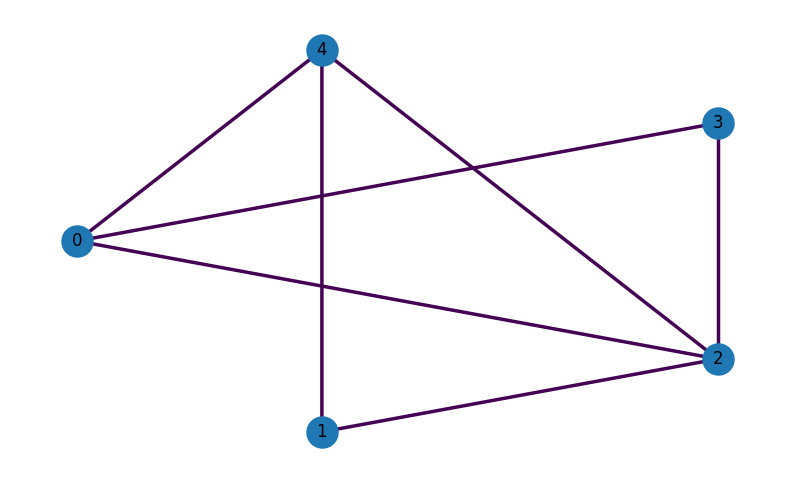

In [4]:
nodes = 5
edge_probability = 0.5
g = nx.generators.fast_gnp_random_graph(nodes, edge_probability, seed=30)

from openqaoa.utilities import plot_graph
plot_graph(g)

In [14]:
maxcut_prob = MaximumCut(g)

maxcut_qubo = maxcut_prob.qubo

In [18]:
hamiltonian = maxcut_qubo.hamiltonian
hamiltonian

In [19]:
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -3.0, Solution: ['11000', '10100', '11100', '11010', '00101', '00011', '01011', '00111']


In [20]:
# initialize model with statevector_simulator
q_sv = QAOA()

# device
qiskit_sv = create_device(location='local', name='qiskit.statevector_simulator')
q_sv.set_device(qiskit_sv)

# circuit properties
q_sv.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# classical optimizer properties
q_sv.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                             cost_progress=True, parameter_log=True)

q_sv.compile(maxcut_qubo)

In [21]:
# initialize model with shot-based simulator
q_shot = QAOA()

# device
qiskit_shot = create_device(location='local', name='qiskit.qasm_simulator')
q_shot.set_device(qiskit_shot)

# circuit properties
q_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties
q_shot.set_backend_properties(n_shots = 200)

# classical optimizer properties
q_shot.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                               cost_progress=True, parameter_log=True)

q_shot.compile(maxcut_qubo)

In [46]:
from qiskit import Aer
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
device_backend = FakeVigo()
device = QasmSimulator.from_backend(device_backend)
noise_model = NoiseModel.from_backend(device)

/tmp/ipykernel_1809776/3184544667.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed in Qiskit 1.0. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo
/tmp/ipykernel_1809776/3184544667.py:5: DeprecationWarning: All fake backend instances based on real device snapshots (`FakeVigo`,`FakeSherbrooke`,...) have been migrated to the `qiskit_ibm_runtime` package. These classes are deprecated as of qiskit 0.46.0 and will be removed in qiskit 1.0.0. To migrate your code, run `pip install qiskit-ibm-runtime` and use `from qiskit_ibm_runtime.fake_provider import FakeExample` instead of `from qiskit.providers.fake_provider import FakeExample`. If you are using a custom fake backend implementation, you don't need to take any action.
  device_backend = FakeVigo()


In [29]:
# initialize model with noisy shot-based simulator
q_noisy_shot = QAOA()

# device

qiskit_noisy_shot = create_device(location='local', name='qiskit.qasm_simulator')
q_noisy_shot.set_device(qiskit_noisy_shot)

# circuit properties
q_noisy_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties
q_noisy_shot.set_backend_properties(n_shots = 200, noise_model = noise_model)

# classical optimizer properties
q_noisy_shot.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                                     cost_progress=True, parameter_log=True)

q_noisy_shot.compile(maxcut_qubo)

In [30]:
q_sv.optimize()
q_shot.optimize()
q_noisy_shot.optimize()

In [31]:
results_sv = q_sv.result
results_shot = q_shot.result
results_noisy_shot = q_noisy_shot.result

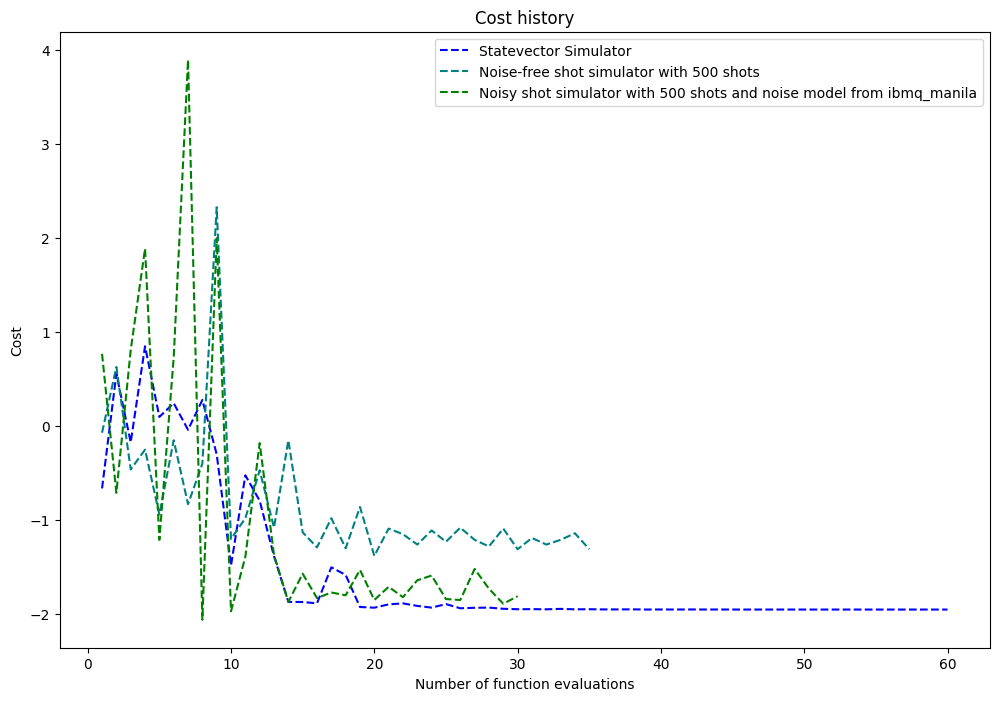

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

fig, ax = results_sv.plot_cost(ax=ax,label='Statevector Simulator')
fig, ax = results_shot.plot_cost(ax=ax,color='teal', label='Noise-free shot simulator with 500 shots')
fig, ax = results_noisy_shot.plot_cost(ax=ax,color='green', label='Noisy shot simulator with 500 shots and noise model from ibmq_manila')

In [33]:
#import problem classes from OQ for easy problem creation
from openqaoa.problems import NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

#Import IBMQ
from qiskit import IBMQ

In [34]:
# Find partition of a list of 7 numbers generated randomly
prob = NumberPartition.random_instance(n_numbers=7)
prob_qubo = prob.qubo

(<Figure size 1000x600 with 2 Axes>, <Axes: >)

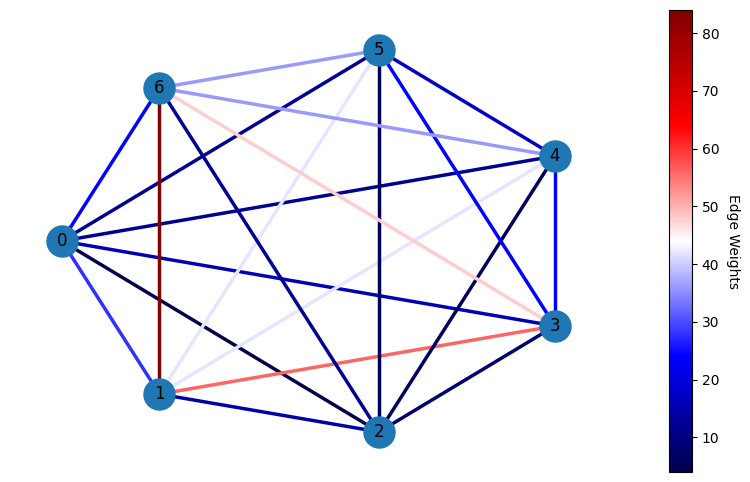

In [35]:
# visualize the QUBO form on a graph
from openqaoa.utilities import plot_graph, graph_from_hamiltonian

#extract Hamiltonain
cost_hamil = prob_qubo.hamiltonian

#convert Hamiltonian to graph
cost_gr = graph_from_hamiltonian(cost_hamil)

#plot the graph
plot_graph(cost_gr)

In [36]:
print(prob_qubo.asdict())

{'terms': [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 5], [4, 6], [5, 6]], 'weights': [28.0, 4.0, 16.0, 12.0, 12.0, 24.0, 14.0, 56.0, 42.0, 42.0, 84.0, 8.0, 6.0, 6.0, 12.0, 24.0, 24.0, 48.0, 18.0, 36.0, 36.0], 'constant': 124, 'n': 7, 'problem_instance': {'problem_type': 'number_partition', 'numbers': [2, 7, 1, 4, 3, 3, 6], 'n_numbers': 7}, 'metadata': {}}


In [37]:
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian

energy, configuration = ground_state_hamiltonian(cost_hamil)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: 0.0, Solution: ['1101000', '1110100', '1110010', '0100110', '1011110', '0100001', '1011001', '0001101', '0001011', '0010111']


In [47]:
qpu_credentials ={
    "hub": "ibm-q",
    "group": "open",
    "project": "main"
}

In [48]:
# initialize model with default configurations
q_qiskit = QAOA()

In [49]:
# device. If qpu_crendetials is not specified,the default hub, group and provider is used.
qiskit_cloud = create_device(location='ibmq', name='ibm_brisbane', **qpu_credentials, as_emulator=True)
q_qiskit.set_device(qiskit_cloud)

# circuit properties
q_qiskit.set_circuit_properties(p=1, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_qiskit.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_qiskit.set_classical_optimizer(method='nelder-mead', maxiter=20, cost_progress=True,
                                 parameter_log=True, optimization_progress=True)

In [50]:
q_qiskit.compile(prob_qubo)
# to use routing, pass your custom function as below
# q_qiskit.compile(prob_qubo, routing_function = my_custom_routing)

In [51]:
print(q_qiskit.backend.parametric_circuit.count_ops()["cx"])
q_qiskit.backend.parametric_circuit.draw()

42


┌───┐                                            »
q523_0: ┤ H ├──■─────────────────────────────────■────■──»
        ├───┤┌─┴─┐┌───────────────────────────┐┌─┴─┐  │  »
q523_1: ┤ H ├┤ X ├┤ Rz(TWOQ_COST_seq0_layer0) ├┤ X ├──┼──»
        ├───┤└───┘└───────────────────────────┘└───┘┌─┴─┐»
q523_2: ┤ H ├───────────────────────────────────────┤ X ├»
        ├───┤                                       └───┘»
q523_3: ┤ H ├────────────────────────────────────────────»
        ├───┤                                            »
q523_4: ┤ H ├────────────────────────────────────────────»
        ├───┤                                            »
q523_5: ┤ H ├────────────────────────────────────────────»
        ├───┤                                            »
q523_6: ┤ H ├────────────────────────────────────────────»
        └───┘                                            »
  c2: 7/═════════════════════════════════════════════════»
                                                         »
«                                                                            »
«q523_0: ───────────────────────────────■────■───────────────────────────────»
«                                       │    │                               »
«q523_1: ───────────────────────────────┼────┼────────────────■──────────────»
«        ┌───────────────────────────┐┌─┴─┐  │              ┌─┴─┐            »
«q523_2: ┤ Rz(TWOQ_COST_seq1_layer0) ├┤ X ├──┼──────────────┤ X ├────────────»
«        └───────────────────────────┘└───┘┌─┴─┐┌───────────┴───┴───────────┐»
«q523_3: ──────────────────────────────────┤ X ├┤ Rz(TWOQ_COST_seq2_layer0) ├»
«                                          └───┘└───────────────────────────┘»
«q523_4: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«q523_5: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«q523_6: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«  c2: 7/════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                                    »
«q523_0: ───────────────────────────────■─────────■──»
«                                       │         │  »
«q523_1: ───────────────────────────────┼────■────┼──»
«        ┌───────────────────────────┐  │  ┌─┴─┐  │  »
«q523_2: ┤ Rz(TWOQ_COST_seq6_layer0) ├──┼──┤ X ├──┼──»
«        └───────────────────────────┘┌─┴─┐└───┘  │  »
«q523_3: ─────────────────────────────┤ X ├───────┼──»
«                                     └───┘     ┌─┴─┐»
«q523_4: ───────────────────────────────────────┤ X ├»
«                                               └───┘»
«q523_5: ────────────────────────────────────────────»
«                                                    »
«q523_6: ────────────────────────────────────────────»
«                                                    »
«  c2: 7/════════════════════════════════════════════»
«                                                    »
«                                                                            »
«q523_0: ────────────────────────────────────────────────────────────■───────»
«                                                                    │       »
«q523_1: ──────────────■─────────────────────────────────────────────┼────■──»
«                      │                                             │    │  »
«q523_2: ──────────────┼─────────────────────────────────────────────┼────┼──»
«                    ┌─┴─┐            ┌───────────────────────────┐  │  ┌─┴─┐»
«q523_3: ────────────┤ X ├────────────┤ Rz(TWOQ_COST_seq7_layer0) ├──┼──┤ X ├»
«        ┌───────────┴───┴───────────┐└───────────────────────────┘┌─┴─┐└───┘»
«q523_4: ┤ Rz(TW

In [53]:
q_qiskit.optimize()

ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not l

In [54]:
rigetti_args ={
    'as_qvm':True,
    'execution_timeout':10,
    'compiler_timeout':100
}

In [55]:
# initialize model with default configurations
q_pyquil = QAOA()

In [57]:
# device
# rigetti_device = create_device(location='qcs', name='Aspen-M-3', **rigetti_args)
rigetti_device = create_device(location='qcs', name='7q-qvm', **rigetti_args)

q_pyquil.set_device(rigetti_device)

# circuit properties
q_pyquil.set_circuit_properties(p=1, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_pyquil.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_pyquil.set_classical_optimizer(method='nelder-mead', maxiter=200, cost_progress=True,
                                 parameter_log=True, optimization_progress=True)

ValueError: Invalid device location, Choose from: dict_keys(['local', 'azure', 'ibmq', 'aws'])